In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Install the requiered packages to run MLFlow

!pip install mlflow --quiet
!pip install pyngrok --quiet

In [3]:
import mlflow
import mlflow.pytorch

In [4]:
get_ipython().system_raw("mlflow ui --port 5000 &")
mlflow.pytorch.autolog()

/opt/conda/lib/python3.10/site-packages/pydantic/_internal/_config.py:321: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
2024-04-24 23:11:26.156117: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 23:11:26.156214: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 23:11:26.298542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[2024-04-24 23:11:27 +0000] [70] [INFO] Starting gunicorn 21.2.0
[2024-04-24 23:11:27 +0000] [70] [INFO] Listening at: http://127.0.0.1:5000 (70

In [5]:
# IMP: please create a auth token from https://dashboard.ngrok.com/auth by creating an account. 
# the below auth ticket will not work for anyone re-running the notebook.
    
from pyngrok import ngrok
from getpass import getpass

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "2ehm1xOCj5re3lx58ZLkcUkHL8S_6Bhb2ykeU2CATAre2hvPf"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://6a6f-34-80-28-171.ngrok-free.app


In [6]:
import pandas as pd
import pydicom
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Load the CSV data
metadata = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')

# Basic CSV EDA
print(metadata.head())
print(metadata.describe())
print(metadata.isnull().sum())

   site_id  patient_id    image_id laterality view   age  cancer  biopsy  \
0        2       10006   462822612          L   CC  61.0       0       0   
1        2       10006  1459541791          L  MLO  61.0       0       0   
2        2       10006  1864590858          R  MLO  61.0       0       0   
3        2       10006  1874946579          R   CC  61.0       0       0   
4        2       10011   220375232          L   CC  55.0       0       0   

   invasive  BIRADS  implant density  machine_id  difficult_negative_case  
0         0     NaN        0     NaN          29                    False  
1         0     NaN        0     NaN          29                    False  
2         0     NaN        0     NaN          29                    False  
3         0     NaN        0     NaN          29                    False  
4         0     0.0        0     NaN          21                     True  
            site_id    patient_id      image_id           age        cancer  \
count  5

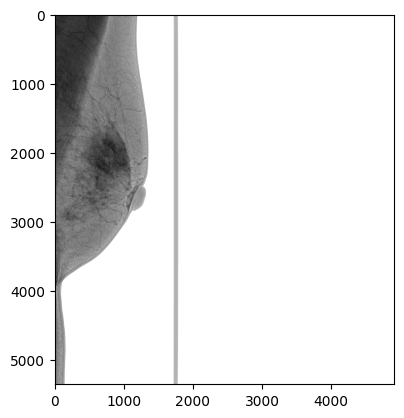

In [7]:
# Function to load DICOM images and convert to array
def load_dicom_image(path):
    dicom_file = pydicom.dcmread(path)
    return dicom_file.pixel_array

# Example of loading and visualizing an image
sample_image_path = '/kaggle/input/rsna-breast-cancer-detection/train_images/10006/1459541791.dcm'
sample_image_array = load_dicom_image(sample_image_path)
plt.imshow(sample_image_array, cmap='gray')
plt.show()

In [8]:
def create_image_path(row, base_path='/kaggle/input/rsna-breast-cancer-detection/train_images'):
    image_id = row['image_id']
    patient_id = row['patient_id']
    return f"{base_path}/{str(patient_id).zfill(5)}/{str(image_id).zfill(8)}.dcm"

metadata['image_path'] = metadata.apply(create_image_path, axis=1)

In [9]:
metadata['image_path'][1]

'/kaggle/input/rsna-breast-cancer-detection/train_images/10006/1459541791.dcm'

In [10]:
metadata['image_path']

0        /kaggle/input/rsna-breast-cancer-detection/tra...
1        /kaggle/input/rsna-breast-cancer-detection/tra...
2        /kaggle/input/rsna-breast-cancer-detection/tra...
3        /kaggle/input/rsna-breast-cancer-detection/tra...
4        /kaggle/input/rsna-breast-cancer-detection/tra...
                               ...                        
54701    /kaggle/input/rsna-breast-cancer-detection/tra...
54702    /kaggle/input/rsna-breast-cancer-detection/tra...
54703    /kaggle/input/rsna-breast-cancer-detection/tra...
54704    /kaggle/input/rsna-breast-cancer-detection/tra...
54705    /kaggle/input/rsna-breast-cancer-detection/tra...
Name: image_path, Length: 54706, dtype: object